# 📘 การคำนวณมุมดวงอาทิตย์ (Solar Angles) — เชียงใหม่, Thailand

เอกสารนี้อธิบายพารามิเตอร์และสูตรที่ใช้ในการคำนวณ **Solar Zenith**, **Solar Elevation**, **Solar Azimuth** และ **มุมตกกระทบบนพื้นผิวเอียง (Incidence angle)** รวมถึงแนวทางการตีความผลลัพธ์ในตารางข้อมูลที่สร้างจากโค้ด Python

## 🔧 การตั้งค่าเบื้องต้น

- **พิกัดสถานที่**\n  `lat_point = 18.899741434351892`, `lon_point = 99.01248957594561` (บริเวณ จ.เชียงใหม่)

- **เขตเวลา**\n  Asia/Bangkok (UTC+7) — ไม่มี DST

- **ความถี่ข้อมูล**\n  ทุก 15 นาที ตั้งแต่ `2021-01-01 00:00` ถึง `2025-12-31 23:45`


In [1]:
import numpy as np
import pandas as pd

# -----------------------------
# พารามิเตอร์พื้นที่และเวลา
# -----------------------------
lat_point = 18.899741434351892   # องศา (เหนือเป็นบวก)
lon_point = 99.01248957594561    # องศา (ตะวันออกเป็นบวก)
tz_offset_hours = 7              # Asia/Bangkok = UTC+7 (ไม่มี DST)

# ความถี่ 15 นาที ตั้งแต่ต้นปี 2021 ถึงปลายปี 2025
dt_index = pd.date_range(
    start="2021-01-01 00:00:00",
    end="2025-12-31 23:45:00",
    freq="15min",
    tz="Asia/Bangkok"
)

# -----------------------------
# ช่วยคำนวณค่ามุมดวงอาทิตย์
# -----------------------------
phi = np.deg2rad(lat_point)  # ละติจูดเป็นเรเดียน
doy = dt_index.dayofyear.values.astype(float)
local_minutes = (dt_index.hour.values * 60 + dt_index.minute.values).astype(float)

# Fractional year (gamma) ตามสูตร NOAA
gamma = (2.0 * np.pi / 365.0) * (doy - 1.0 + (local_minutes - 720.0) / 1440.0)

# Equation of Time (นาที)
EoT = 229.18 * (
    0.000075
    + 0.001868 * np.cos(gamma)
    - 0.032077 * np.sin(gamma)
    - 0.014615 * np.cos(2.0 * gamma)
    - 0.040849 * np.sin(2.0 * gamma)
)

# Solar declination (เรเดียน)
delta = (
    0.006918
    - 0.399912 * np.cos(gamma)
    + 0.070257 * np.sin(gamma)
    - 0.006758 * np.cos(2.0 * gamma)
    + 0.000907 * np.sin(2.0 * gamma)
    - 0.002697 * np.cos(3.0 * gamma)
    + 0.00148  * np.sin(3.0 * gamma)
)

# Solar time offset (นาที) และ Hour angle (องศา)
time_offset = EoT + 4.0 * lon_point - 60.0 * tz_offset_hours
solar_minutes = local_minutes + time_offset
H_deg = solar_minutes / 4.0 - 180.0
H_rad = np.deg2rad(H_deg)

# -----------------------------
# Zenith, Elevation, Azimuth
# -----------------------------
cos_zenith = np.sin(phi) * np.sin(delta) + np.cos(phi) * np.cos(delta) * np.cos(H_rad)
cos_zenith = np.clip(cos_zenith, -1.0, 1.0)

zenith_deg = np.degrees(np.arccos(cos_zenith))
elevation_deg = 90.0 - zenith_deg

azimuth_deg = (
    np.degrees(np.arctan2(np.sin(H_rad), np.cos(H_rad) * np.sin(phi) - np.tan(delta) * np.cos(phi)))
    + 180.0
)
azimuth_deg = np.mod(azimuth_deg, 360.0)

# -----------------------------
# มุมตกกระทบบนพื้นผิวเอียง (Incidence)
# -----------------------------
tilt_surface_deg = 0.0      # β = 0° แนวนอน
azimuth_surface_deg = 180.0 # ψ_s = 180° หันไปทิศใต้

beta = np.deg2rad(tilt_surface_deg)
psi_s = np.deg2rad(azimuth_surface_deg)

alpha_rad = np.deg2rad(elevation_deg)
psi_rad = np.deg2rad(azimuth_deg)

cos_incidence = np.sin(alpha_rad) * np.cos(beta) + np.cos(alpha_rad) * np.sin(beta) * np.cos(psi_rad - psi_s)
cos_incidence = np.clip(cos_incidence, -1.0, 1.0)

incidence_deg = np.degrees(np.arccos(cos_incidence))
incidence_deg = np.where(elevation_deg > 0.0, incidence_deg, np.nan)  # มาส์กกลางคืน

# -----------------------------
# รวมเป็น DataFrame
# -----------------------------
df = pd.DataFrame({
    "equation_of_time_min": EoT,
    "zenith_deg": zenith_deg,
    "elevation_deg": elevation_deg,
    "azimuth_deg": azimuth_deg,
    "declination_deg": np.degrees(delta),
    "hour_angle_deg": H_deg,
    "incidence_deg": incidence_deg,
}, index=dt_index)

df.head(10)


,equation_of_time_min,zenith_deg,elevation_deg,azimuth_deg,declination_deg,hour_angle_deg,incidence_deg
2021-01-01 00:00:00+07:00,-2.679267,172.503172,-82.503172,234.819450,-23.095402,-186.657327,NaN
2021-01-01 00:15:00+07:00,-2.683962,175.003442,-85.003442,212.404922,-23.094656,-182.908501,NaN
2021-01-01 00:30:00+07:00,-2.688657,175.733137,-85.733137,169.553291,-23.093908,-179.159675,NaN
2021-01-01 00:45:00+07:00,-2.693351,174.005991,-84.005991,135.186242,-23.093160,-175.410848,NaN
2021-01-01 01:00:00+07:00,-2.698045,171.161321,-81.161321,119.756417,-23.092411,-171.662022,NaN
2021-01-01 01:15:00+07:00,-2.702738,167.968149,-77.968149,112.479313,-23.091661,-167.913195,NaN
2021-01-01 01:30:00+07:00,-2.707431,164.643540,-74.643540,108.582816,-23.090911,-164.164368,NaN
2021-01-01 01:45:00+07:00,-2.712123,161.258673,-71.258673,106.324521,-23.090159,-160.415541,NaN
2021-01-01 02:00:00+07:00,-2.716816,157.842632,-67.842632,104.970583,-23.089407,-156.666714,NaN
2021-01-01 02:15:00+07:00,-2.721507,154.409490,-64.409490,104.166979,-23.088653,-152.917887,NaN


## 📊 คำอธิบายคอลัมน์ที่ใช้ในผลลัพธ์

- `equation_of_time_min` *(นาที)* — ความต่างระหว่างเวลาแสงอาทิตย์จริงกับเวลาเฉลี่ยของนาฬิกา; เกิดจากวงโคจรโลกเป็นวงรีและแกนโลกเอียง
- `zenith_deg` *(องศา)* — มุมระหว่างแนวดิ่งขึ้นจากจุดสังเกตกับเส้นตรงไปยังดวงอาทิตย์ (0°=เหนือศีรษะ, 90°=ขอบฟ้า)
- `elevation_deg` *(องศา)* — มุมสูงของดวงอาทิตย์เหนือขอบฟ้า (>0°=กลางวัน, ≤0°=กลางคืน)
- `azimuth_deg` *(องศา)* — ทิศทางของดวงอาทิตย์บนระนาบราบ (0°=เหนือ, 90°=ตะวันออก, 180°=ใต้, 270°=ตะวันตก)
- `declination_deg` *(องศา)* — มุมระหว่างรังสีดวงอาทิตย์กับระนาบศูนย์สูตรโลก (ประมาณ ±23.45°)
- `hour_angle_deg` *(องศา)* — มุมบอกตำแหน่งดวงอาทิตย์เทียบกับเส้นเมริเดียนท้องถิ่น (0°=เที่ยงวันดวงอาทิตย์, 15°/ชั่วโมง)
- `incidence_deg` *(องศา)* — มุมระหว่างรังสีดวงอาทิตย์กับพื้นผิวเอียงที่กำหนด; ตั้งเป็น `NaN` เมื่อ `elevation_deg ≤ 0` (กลางคืน)


## 🧮 สูตรคำนวณที่ใช้ (LaTeX)

ให้ $\phi$ = ละติจูด (เรเดียน), $\delta$ = solar declination (เรเดียน), $H$ = hour angle (องศา)

1. **Fractional year ($\gamma$)**

$$\gamma = \frac{2\pi}{365}\left(\text{DOY} - 1 + \frac{\text{local minutes} - 720}{1440}\right)$$

2. **Equation of Time (EoT; นาที)**

$$\text{EoT} = 229.18 \big(0.000075 + 0.001868\cos\gamma - 0.032077\sin\gamma - 0.014615\cos(2\gamma) - 0.040849\sin(2\gamma)\big)$$

3. **Solar Declination ($\delta$)**

$$\delta = 0.006918 - 0.399912\cos\gamma + 0.070257\sin\gamma - 0.006758\cos(2\gamma) + 0.000907\sin(2\gamma) - 0.002697\cos(3\gamma) + 0.00148\sin(3\gamma)$$

4. **Solar Time offset (นาที) และ Hour Angle (องศา)**

$$\text{offset} = \text{EoT} + 4\cdot\text{longitude} - 60\cdot\text{TZ} \quad\Rightarrow\quad H = \frac{\text{local minutes} + \text{offset}}{4} - 180 \; (\text{deg})$$

5. **Solar Zenith ($\theta_z$) และ Elevation ($\alpha$)**

$$\cos\theta_z = \sin\phi\,\sin\delta + \cos\phi\,\cos\delta\,\cos H \quad,\quad \alpha = 90^\circ - \theta_z$$

6. **Solar Azimuth ($\psi$; 0–360° จากทิศเหนือ หมุนตามเข็มนาฬิกา)**

$$\psi = \operatorname{atan2}\big(\sin H,\; \cos H\,\sin\phi - \tan\delta\,\cos\phi\big) + 180^\circ$$

7. **Incidence Angle บนพื้นผิวเอียง ($\theta_i$)**

ให้ความเอียงพื้นผิว $\beta$ (0°=แนวนอน, 90°=แนวตั้ง) และอาซิมุทพื้นผิว $\psi_s$ (0°=เหนือ, 90°=ตะวันออก, 180°=ใต้, 270°=ตะวันตก)\n
$$\cos\theta_i = \sin\alpha\,\cos\beta + \cos\alpha\,\sin\beta\,\cos(\psi - \psi_s)$$

- สำหรับพื้นผิวแนวนอน: $\beta = 0^\circ \Rightarrow \theta_i = \theta_z$


In [2]:
# 🔎 ตรวจสอบกลางวัน/กลางคืน
mask_daylight = df['elevation_deg'] > 0
first_day = df.loc['2021-01-01']
first_valid = first_day[mask_daylight.loc['2021-01-01']].index.min()
first_valid


Timestamp('2021-01-01 07:15:00+0700', tz='Asia/Bangkok')

## 📈 การแสดงผลกราฟตัวอย่าง (Solar Elevation สำหรับวันแรก)

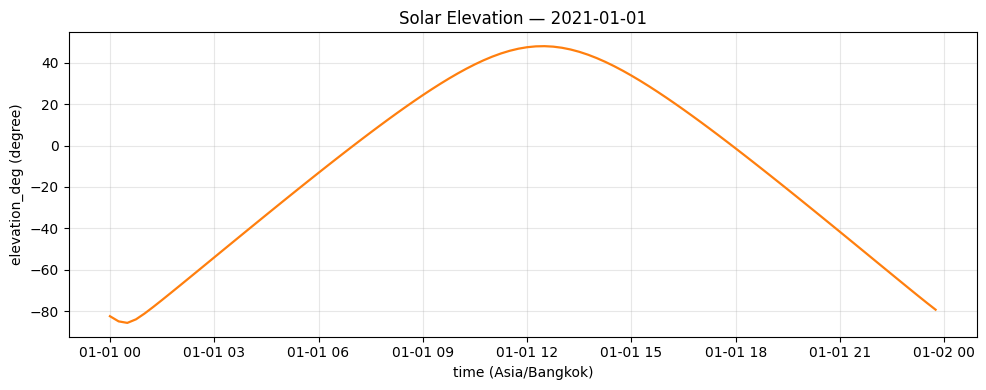

In [5]:
import matplotlib.pyplot as plt

sel = df.loc['2021-01-01']
plt.figure(figsize=(10, 4))
plt.plot(sel.index, sel['elevation_deg'], color='tab:orange', lw=1.6)
plt.title('Solar Elevation — 2021-01-01')
plt.xlabel('time (Asia/Bangkok)')
plt.ylabel('elevation_deg (degree)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 💾 การส่งออกไฟล์ (ตัวเลือก)

In [6]:
# บันทึกผลลัพธ์เป็น CSV (เลือกใช้ตามต้องการ)
df.to_csv('solar_angles_2021_2025_15min_chiangmai.csv', encoding='utf-8')

# หรือบันทึกรายปีเพื่อลดขนาดไฟล์
# for year in range(2021, 2026):
#     df.loc[str(year)].to_csv(f'solar_angles_{year}_15min_chiangmai.csv', encoding='utf-8')
